# DeepDream

### ___Enhanced Deepdream___

This notebook produces DeepDream images from user-supplied photos using Google's pretrained Inception neural network. It can be used as a starting point for further exploration in visualizing convolutional neural networks.

### 1) install prerequisites & initialize startup. Loading the model graph

This downloads the file automatically and unpacks it locally to the Colab kernel.

In [0]:
!wget -nc --no-check-certificate https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip && unzip -n inception5h.zip

# if the image you want to use is an online img URL you can set it here, otherwise if you wish to upload
# desired image. ignore this and continue to next steps 
!wget -nc https://photos.zillowstatic.com/cc_ft_1536/ISr90krdf64kzx1000000000.jpg

file_contents = open("ISr90krdf64kzx1000000000.jpg").read()  
%tensorflow_version 1.x
from io import BytesIO
from IPython.display import clear_output, Image, display
import numpy as np
import PIL.Image
import tensorflow as tf
from __future__ import print_function

model_fn = 'tensorflow_inception_graph.pb'

# creating TensorFlow session and loading the model
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

--2020-05-01 02:40:30--  https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 2a00:1450:4013:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49937555 (48M) [application/zip]
Saving to: ‘inception5h.zip’

inception5h.zip     100%[===================>]  47.62M  60.9MB/s    in 0.8s    

2020-05-01 02:40:31 (60.9 MB/s) - ‘inception5h.zip’ saved [49937555/49937555]

Archive:  inception5h.zip
  inflating: imagenet_comp_graph_label_strings.txt  
  inflating: tensorflow_inception_graph.pb  
  inflating: LICENSE                 
--2020-05-01 02:40:34--  https://photos.zillowstatic.com/cc_ft_1536/ISr90krdf64kzx1000000000.jpg
Resolving photos.zillowstatic.com (photos.zillowstatic.com)... 52.222.158.118, 52.222.158.32, 52.222.158.113, ...
Connecting to photos.zillowstatic.com (photos.zill

W0501 02:40:44.718693 140144972601216 deprecation.py:323] From <ipython-input-1-f782d546baba>:18: __init__ (from tensorflow.python.platform.gfile) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.gfile.GFile.


load core deepdream code below:


In [0]:
# These parameters let us control the strenth of the deepdream.
octave_n = 4
octave_scale = 1.4
iter_n = 10
strength = 200

# Helper function that uses TensorFlow to resize an image
def resize(img, new_size):
    return sess.run(tf.image.resize_bilinear(img[np.newaxis,:], new_size))[0]

# Apply gradients to an image in a seires of tiles
def calc_grad_tiled(img, t_grad, tile_size=256):
    '''Random shifts are applied to the image to blur tile boundaries over
    multiple iterations.'''
    h, w = img.shape[:2]
    sx, sy = np.random.randint(tile_size, size=2)
    # We randomly roll the image in x and y to avoid seams between tiles.
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-tile_size//2, tile_size),tile_size):
        for x in range(0, max(w-tile_size//2, tile_size),tile_size):
            sub = img_shift[y:y+tile_size,x:x+tile_size]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+tile_size,x:x+tile_size] = g
    imggrad = np.roll(np.roll(grad, -sx, 1), -sy, 0)
    # Add the image gradient to the image and return the result
    return img + imggrad*(strength * 0.01 / (np.abs(imggrad).mean()+1e-7))

# Applies deepdream at multiple scales
def render_deepdream(t_obj, input_img, show_steps = True):
    # Collapse the optimization objective to a single number (the loss)
    t_score = tf.reduce_mean(t_obj)
    # We need the gradient of the image with respect to the objective
    t_grad = tf.gradients(t_score, t_input)[0]

    # split the image into a number of octaves (laplacian pyramid)
    img = input_img
    octaves = []
    for i in range(octave_n-1):
        lo = resize(img, np.int32(np.float32(img.shape[:2])/octave_scale))
        octaves.append(img-resize(lo, img.shape[:2]))
        img = lo

    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for i in range(iter_n):
            img = calc_grad_tiled(img, t_grad)
        if show_steps:
            clear_output()
            showarray(img)
    return img

### 2) Load image 

In [0]:
from google.colab import files
uploaded = files.upload()

Saving vv.jpg to vv.jpg


run above to select desired photo. make sure it is finished uploading before proceeding below:


### 2) show image 

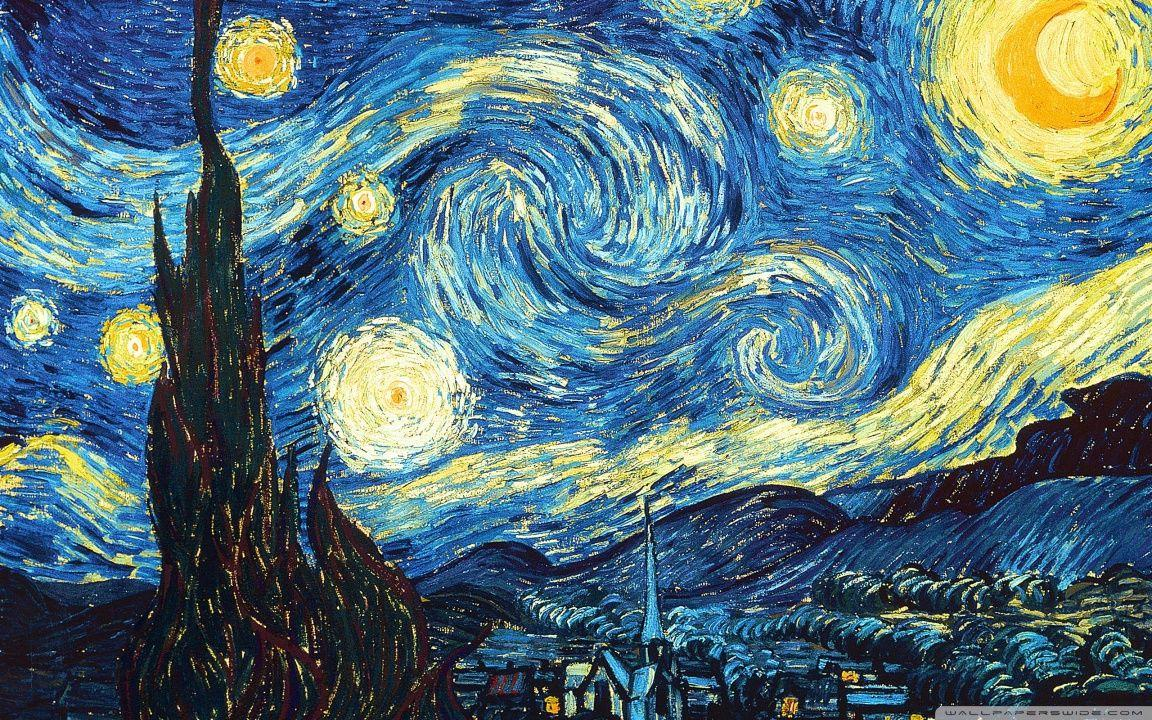

In [0]:
if type(uploaded) is not dict: uploaded = uploaded.files  ## Deal with filedit versions
file_contents = uploaded[uploaded.keys()[0]]
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
img0 = sess.run(tf.image.decode_image(file_contents))
showarray(img0)

### 4) Let's deep dream !

You can adjust the sliders to change the strength of the deep dream, and how many scales it is applied over.

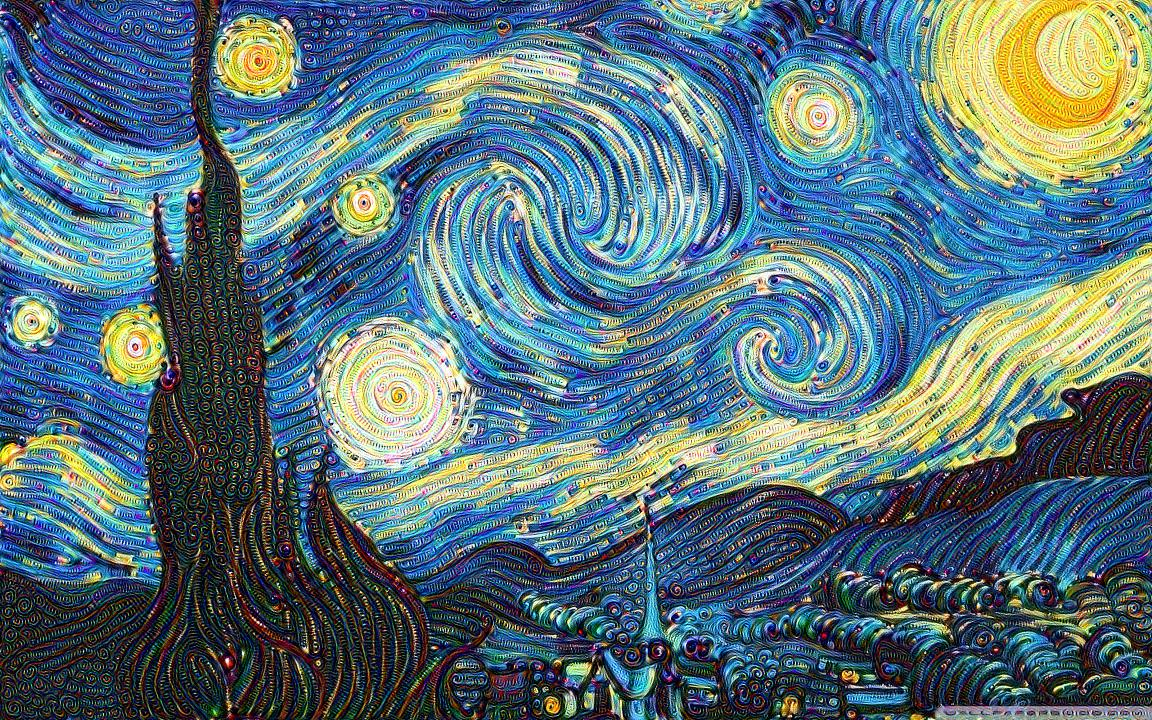

In [0]:
octave_n = 1 #@param {type:"slider", max: 10}
octave_scale = 1.8 #@param {type:"number"}
iter_n = 28 #@param {type:"slider", max: 50}
strength = 511 #@param {type:"slider", max: 1000}
layer = "mixed3b"  #@param ["mixed3a", "mixed3b", "mixed4a", "mixed4c", "mixed5a","mixed5b"]

final = render_deepdream(tf.square(T(layer)), img0)


### 5) Individual neurons

We can also try and optimize not against an entire layer but just one neuron's activity:

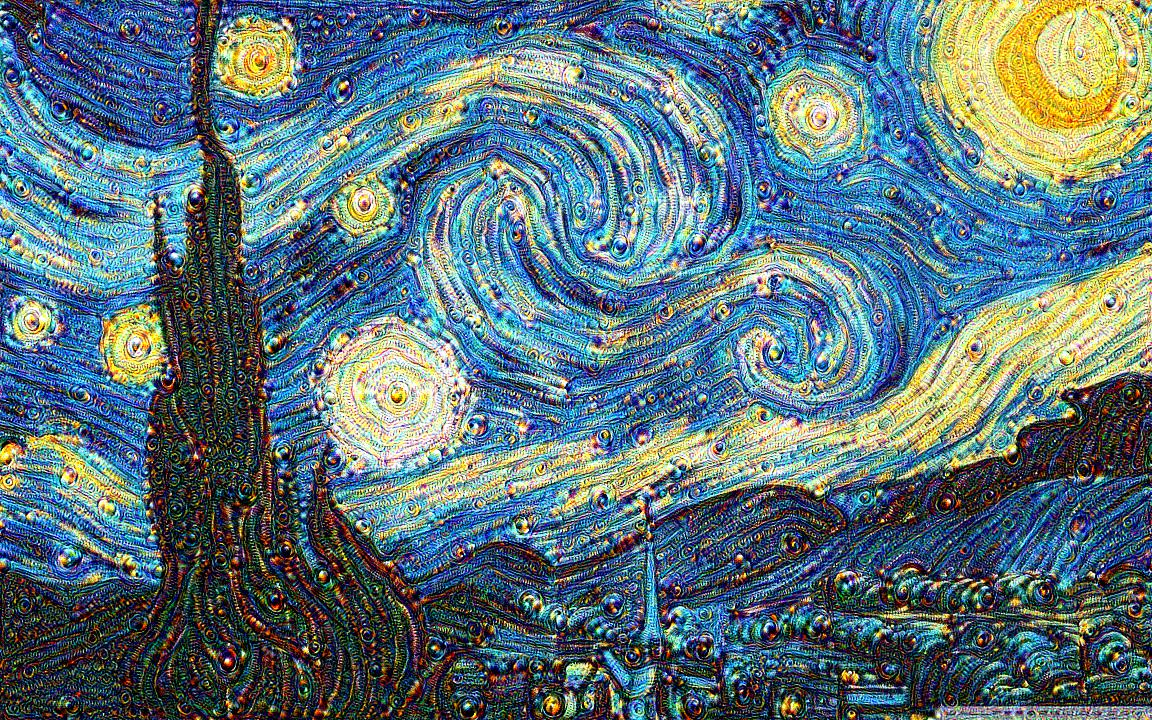

In [0]:
feature_channel = 20 #@param {type:"slider", max: 512}
layer = "mixed4d_3x3_bottleneck_pre_relu"  #@param ["mixed4d_3x3_bottleneck_pre_relu", "mixed3a", "mixed3b", "mixed4a", "mixed4c", "mixed5a", "mixed5b"]
if feature_channel >= T(layer).shape[3]:
  print("Feature channel exceeds size of layer ", layer, " feature space. ")
  print("Choose a smaller channel number.")
else:
  render_deepdream(T(layer)[:,:,:,feature_channel], final)

### 6) Zooming iterative DeepDream

We can enter completely immersive worlds by iteratively sooming into the picture:

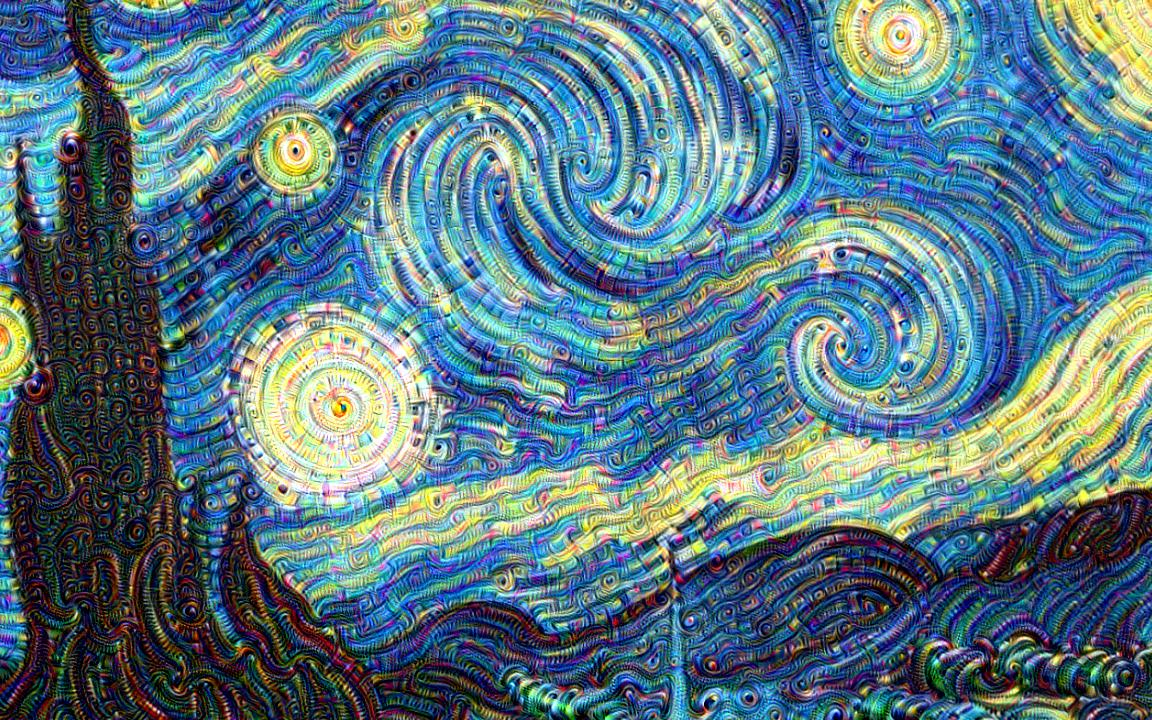

In [0]:
layer = "mixed4d_3x3_bottleneck_pre_relu"  #@param ["mixed4d_3x3_bottleneck_pre_relu", "mixed3a", "mixed3b", "mixed4a", "mixed4c", "mixed5a"]
iter_n = 9 #@param {type:"slider", max: 50}
strength = 275 #@param {type:"slider", max: 1000}
zooming_steps = 4 #@param {type:"slider", max: 512}
zoom_factor = 1.1 #@param {type:"number"}

frame = final
img_y, img_x, _ = img0.shape
for i in range(zooming_steps):
  frame = render_deepdream(tf.square(T(layer)), frame, False)
  clear_output()
  showarray(frame)
  newsize = np.int32(np.float32(frame.shape[:2])*zoom_factor)
  frame = resize(frame, newsize)
  frame = frame[(newsize[0]-img_y)//2:(newsize[0]-img_y)//2+img_y,
                (newsize[1]-img_x)//2:(newsize[1]-img_x)//2+img_x,:]
  

### Further reading for the curious

 *   Original [DeepDream (Inceptionism) blog post](https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html)
 *   [Original DeepDream algorithm](https://github.com/google/deepdream/blob/master/dream.ipynb) with Caffe

## 7) Diving deeper into the Inception Model

Lets look a bit deeper into the Inception Model and visualize the layers. Each layer will produce a very different result when used in deep dreaming.

In [0]:
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))

for layer in layers:
  print('Layer:', layer)

Number of layers 59
Total number of feature channels: 7548
Layer: import/conv2d0_pre_relu/conv
Layer: import/conv2d1_pre_relu/conv
Layer: import/conv2d2_pre_relu/conv
Layer: import/mixed3a_1x1_pre_relu/conv
Layer: import/mixed3a_3x3_bottleneck_pre_relu/conv
Layer: import/mixed3a_3x3_pre_relu/conv
Layer: import/mixed3a_5x5_bottleneck_pre_relu/conv
Layer: import/mixed3a_5x5_pre_relu/conv
Layer: import/mixed3a_pool_reduce_pre_relu/conv
Layer: import/mixed3b_1x1_pre_relu/conv
Layer: import/mixed3b_3x3_bottleneck_pre_relu/conv
Layer: import/mixed3b_3x3_pre_relu/conv
Layer: import/mixed3b_5x5_bottleneck_pre_relu/conv
Layer: import/mixed3b_5x5_pre_relu/conv
Layer: import/mixed3b_pool_reduce_pre_relu/conv
Layer: import/mixed4a_1x1_pre_relu/conv
Layer: import/mixed4a_3x3_bottleneck_pre_relu/conv
Layer: import/mixed4a_3x3_pre_relu/conv
Layer: import/mixed4a_5x5_bottleneck_pre_relu/conv
Layer: import/mixed4a_5x5_pre_relu/conv
Layer: import/mixed4a_pool_reduce_pre_relu/conv
Layer: import/mixed4b_1

For example try deepdreaming with the layer '`mixed4a_3x3_pre_relu`'

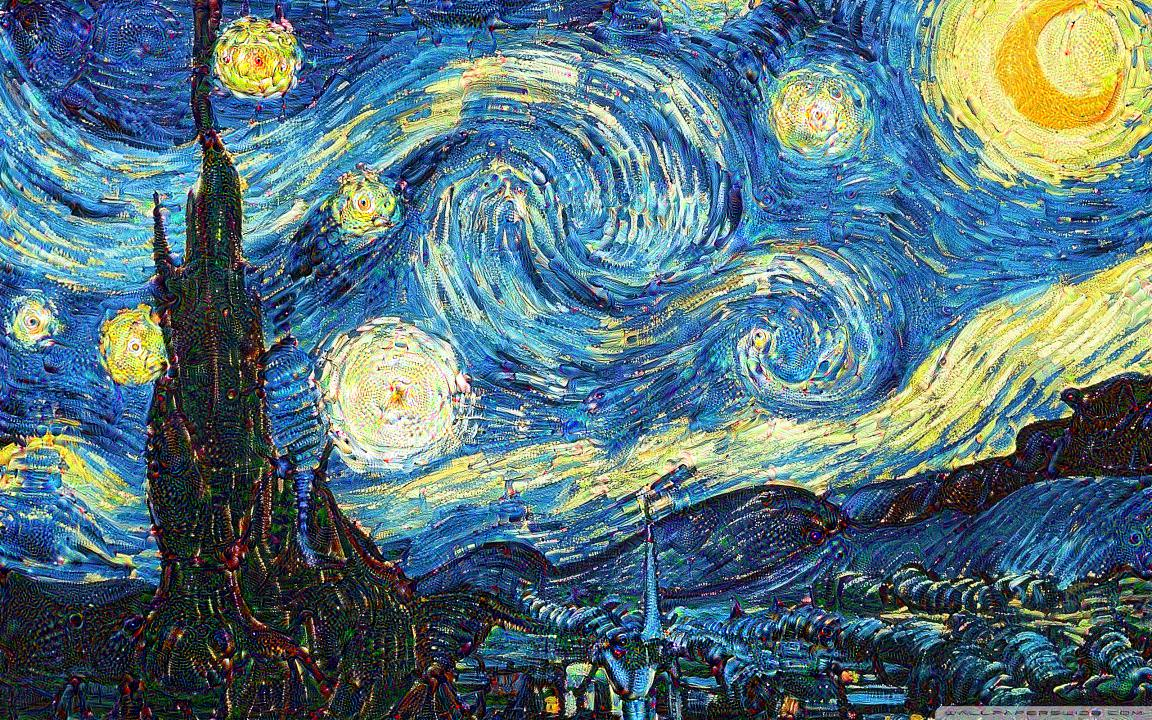

In [0]:
layer = "mixed5b_5x5_bottleneck_pre_relu",
final2 = render_deepdream(tf.square(T(layer)), final)
layer =  "mixed4e_3x3_bottleneck_pre_relu",
final = render_deepdream(tf.square(T(layer)), final2)